In [7]:
conda list

# packages in environment at /home/tomar.y/miniconda3/envs/RSNA:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
argon2-cffi               20.1.0           py37h7b6447c_1  
async_generator           1.10             py37h28b3542_0  
attrs                     20.2.0                     py_0  
backcall                  0.2.0                      py_0  
bash                      5.0.018              h14c3975_0  
blas                      1.0                         mkl  
bleach                    3.2.1                      py_0  
brotlipy                  0.7.0           py37h7b6447c_1000  
ca-certificates           2020.7.22                     0  
certifi                   2020.6.20                py37_0  
cffi                      1.14.3           py37he30daa8_0  
chardet                   3.0.4                 py37_1003  
cryptography              3.1.1            py37h1ba5d50_0  
cycler                  

In [12]:
import os
import numpy as np
import pandas as pd
import pydicom as dcm
import matplotlib
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import gdcm
from matplotlib import animation, rc
from plotly.subplots import make_subplots
import plotly.graph_objs as go

train_dir = "/scratch/tomar.y/kaggle/train"
files = glob.glob("/scratch/tomar.y/kaggle/train/*/*/*.dcm")

rc('animation', html='jshtml')

np.random.seed(666)

In [13]:
#train = pd.read_csv("/scratch/tomar.y/kaggle/train.csv")
test = pd.read_csv("/scratch/tomar.y/kaggle/test.csv")

In [15]:
test

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID
0,df06fad17bc3,857e3d760445,c3163725fcf6
1,df06fad17bc3,857e3d760445,d54a8daaf836
2,df06fad17bc3,857e3d760445,bdc531b699cd
3,df06fad17bc3,857e3d760445,9e6a68e27df0
4,df06fad17bc3,857e3d760445,25e3307ba7da
...,...,...,...
146848,84a57a6bc1b4,cf16044f2cda,5f34e0c61c00
146849,84a57a6bc1b4,cf16044f2cda,ccaa309b60da
146850,84a57a6bc1b4,cf16044f2cda,a274c8d0916e
146851,84a57a6bc1b4,cf16044f2cda,a702de2c99c6


**********************************************************Exploratory Data Analysis***********************************************************************

In [14]:
cols = [
    'pe_present_on_image','negative_exam_for_pe', 'qa_motion',
    'qa_contrast', 'flow_artifact', 'rv_lv_ratio_gte_1',
    'rv_lv_ratio_lt_1', 'leftsided_pe', 'chronic_pe',
    'true_filling_defect_not_pe', 'rightsided_pe',
    'acute_and_chronic_pe', 'central_pe', 'indeterminate'
]

fig = make_subplots(rows=5, cols=3)

traces = [
    go.Bar(
        x=[0,1],
        y=[
            len(train[train[col]==0]),
            len(train[train[col]==1])
        ],
        name=col,
        text = [
            str(round(100 * len(train[train[col]==0]) / len(train), 2)) + '%',
            str(round(100 * len(train[train[col]==1]) / len(train), 2)) + '%'
        ],
        textposition='auto'
    ) for col in cols
]

for i in range(len(traces)):
    fig.append_trace(traces[i], (i // 3) + 1, (i % 3) +1)
    
fig.update_layout(
    title_text='Train Columns',
    height=1200,
    width=1000
)

fig.show()

KeyError: 'pe_present_on_image'

In [ ]:
x = train.drop(['StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID'], axis=1).sum(axis=0).sort_values().reset_index()
x.columns = ['column', 'nonzero_records']

fig = px.bar(
    x, 
    x='nonzero_records', 
    y='column', 
    orientation='h', 
    title='Columns and non zero samples', 
    height=800, 
    width=800
)

fig.show()

In [ ]:
data = train.drop(['StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID'], axis=1).astype(bool).sum(axis=1).reset_index()
data.columns = ['row', 'count']
data = data.groupby(['count'])['row'].count().reset_index()

fig = px.bar(
    data, 
    y=data['row'], 
    x="count", 
    title='Number of activations in for every sample in training set', 
    width=800, 
    height=500
)

fig.show()

In [ ]:
data = train.drop(['StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID'], axis=1).astype(bool).sum(axis=1).reset_index()
data.columns = ['row', 'count']
data = data.groupby(['count'])['row'].count().reset_index()

fig = px.pie(
    data, 
    values=round((100 * data['row'] / len(train)), 2), 
    names="count", 
    title='Number of activations for every sample (Percent)', 
    width=800, 
    height=500
)

fig.show()

In [ ]:
data = train[[
    'pe_present_on_image', 'negative_exam_for_pe', 'qa_motion', 
    'qa_contrast', 'flow_artifact', 'rv_lv_ratio_gte_1', 
    'rv_lv_ratio_lt_1', 'leftsided_pe', 'chronic_pe', 
    'true_filling_defect_not_pe', 'rightsided_pe', 
    'acute_and_chronic_pe', 'central_pe', 'indeterminate'
]]

f = plt.figure(figsize=(16, 16))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.shape[1]), data.columns, fontsize=13, rotation=70)
plt.yticks(range(data.shape[1]), data.columns, fontsize=13)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=13)

In [ ]:
print('Total number (dirictories) in training set {}'.format(len(os.listdir(TRAIN_DIR))))

************************************************************Image Analysis****************************************************************************

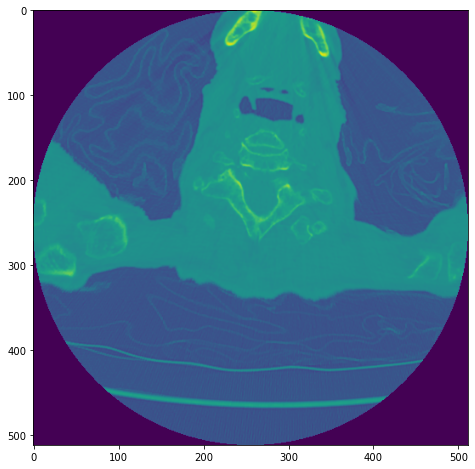

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(
    dcm.dcmread("/scratch/tomar.y/kaggle/train/69b28bee6ef4/2d69fe0ea1b1/9a6d9044a729.dcm").pixel_array
)

In [17]:
test_image = dcm.dcmread("/scratch/tomar.y/kaggle/train/69b28bee6ef4/2d69fe0ea1b1/9a6d9044a729.dcm").pixel_array
print('Image shape: ', test_image.shape)

Image shape:  (512, 512)


In [18]:
dcm.dcmread("/scratch/tomar.y/kaggle/train/69b28bee6ef4/2d69fe0ea1b1/9a6d9044a729.dcm")

Dataset.file_meta -------------------------------
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: "['ORIGINAL', 'PRIMARY', 'AXIAL']"
(0008, 0016) SOP Class UID                       UI: 80e30f500244
(0008, 0018) SOP Instance UID                    UI: 9a6d9044a729
(0008, 0060) Modality                            CS: 'CT'
(0018, 0050) Slice Thickness                     DS: "1.0"
(0018, 0060) KVP                                 DS: "100.0"
(0018, 1120) Gantry/Detector Tilt                DS: "0.0"
(0018, 1130) Table Height                        DS: "141.0"
(0018, 1140) Rotation Direction                  CS: 'CW'
(0018, 1151) X-Ray Tube Current                  IS: "456"
(0018, 1152) Exposure                            IS: "159"
(0018, 1210) Convolution Kernel                  SH: 'FC08-H'

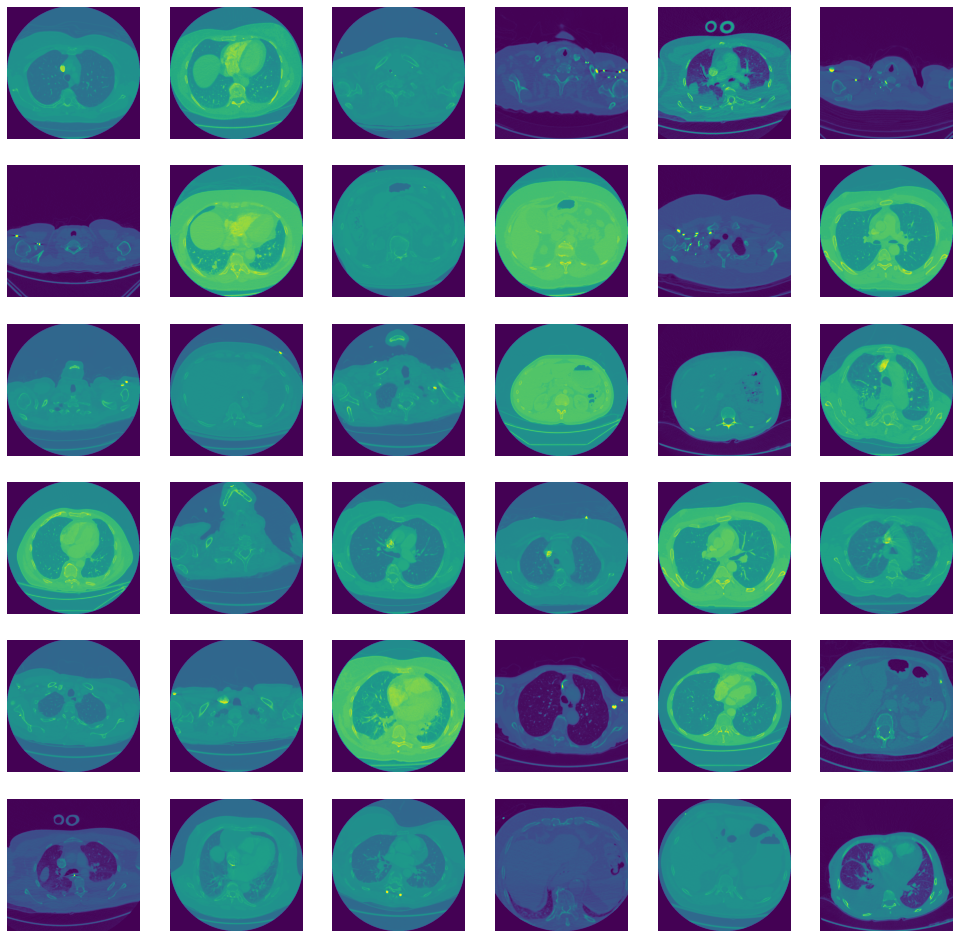

In [19]:
f, plots = plt.subplots(6, 6, sharex='col', sharey='row', figsize=(17, 17))

for i in range(36):
    plots[i // 6, i % 6].axis('off')
    plots[i // 6, i % 6].imshow(dcm.dcmread(np.random.choice(files[:10000])).pixel_array)

******************************************************Image Animation**********************************************************